We analyze titration data to determine the half-equivalence point and apparent pKa of ethanoic acid under different NaCl concentrations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

In [2]:
def extract_runs(df):
    """
    Extracts individual runs from the wide-format CSV.
    Returns a dictionary of DataFrames, where keys are run names (e.g., 'Run 1', 'Latest').
    """
    runs = {}
    columns = df.columns
    prefixes = set([col.split(":")[0] for col in columns if ":" in col])

    for prefix in prefixes:
        run_cols = [col for col in columns if col.startswith(prefix)]
        run_df = df[run_cols].copy()

        run_df.columns = [col.split(": ")[1] for col in run_cols]
        run_df = run_df.dropna(how="all")

        if "Time (min)" in run_df.columns and "pH" in run_df.columns:
            run_df = run_df.dropna(subset=["Time (min)", "pH"])
            run_df = run_df.sort_values("Time (min)")

            runs[prefix] = run_df

    return runs


def calculate_derivatives(df, time_col="Time (min)", ph_col="pH"):
    """
    Calculates 1st and 2nd derivatives of pH w.r.t Time.
    """
    t = df[time_col].values
    ph = df[ph_col].values
    dpH = np.gradient(ph, t)
    d2pH = np.gradient(dpH, t)

    df["dpH/dt"] = dpH
    df["d2pH/dt2"] = d2pH

    return df


def find_equivalence_point(df, time_col="Time (min)"):
    """
    Finds the equivalence point time where 1st derivative is max.
    """
    max_idx = df["dpH/dt"].idxmax()
    eq_time = df.loc[max_idx, time_col]
    eq_pH = df.loc[max_idx, "pH"]

    return eq_time, eq_pH


def analyze_titration(df, run_name):
    """
    Analyzes a single titration run.
    """
    df = calculate_derivatives(df)
    eq_time, eq_pH = find_equivalence_point(df)

    half_eq_time = eq_time / 2
    half_eq_pH = np.interp(half_eq_time, df["Time (min)"], df["pH"])

    return {
        "run_name": run_name,
        "eq_time": eq_time,
        "eq_pH": eq_pH,
        "half_eq_time": half_eq_time,
        "half_eq_pH": half_eq_pH,
        "data": df,
    }

In [3]:
files = [
    ("data/ms besant go brr - 0m nacl.csv", 0.0),
    ("data/ms besant go brr - 1m nacl.csv", 1.0),
]

results = []

for filepath, nacl_conc in files:
    print(f"Processing {filepath} (NaCl: {nacl_conc} M)...")
    try:
        df_raw = pd.read_csv(filepath)
        runs = extract_runs(df_raw)

        for run_name, run_df in runs.items():
            print(f"  Analyzing {run_name}...")
            if len(run_df) < 10:
                print(f"    Skipping {run_name} (not enough data points)")
                continue

            analysis = analyze_titration(run_df, f"{nacl_conc}M - {run_name}")
            analysis["nacl_conc"] = nacl_conc
            results.append(analysis)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")

print("\nAnalysis Complete.")

Processing data/ms besant go brr - 0m nacl.csv (NaCl: 0.0 M)...
  Analyzing Run 1...
  Analyzing Latest...
Processing data/ms besant go brr - 1m nacl.csv (NaCl: 1.0 M)...
  Analyzing Latest...

Analysis Complete.


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display']

   NaCl Concentration (M)            Run  Equivalence Time (min)  \
0                     0.0   0.0M - Run 1                7.266667   
1                     0.0  0.0M - Latest                7.866667   
2                     1.0  1.0M - Latest                8.733333   

   Equivalence pH  Half-Equivalence Time (min)  Half-Equivalence pH (pKa)  
0        9.489917                     3.633333                   5.477512  
1       10.107164                     3.933333                   5.424393  
2        9.590516                     4.366667                   5.273643  


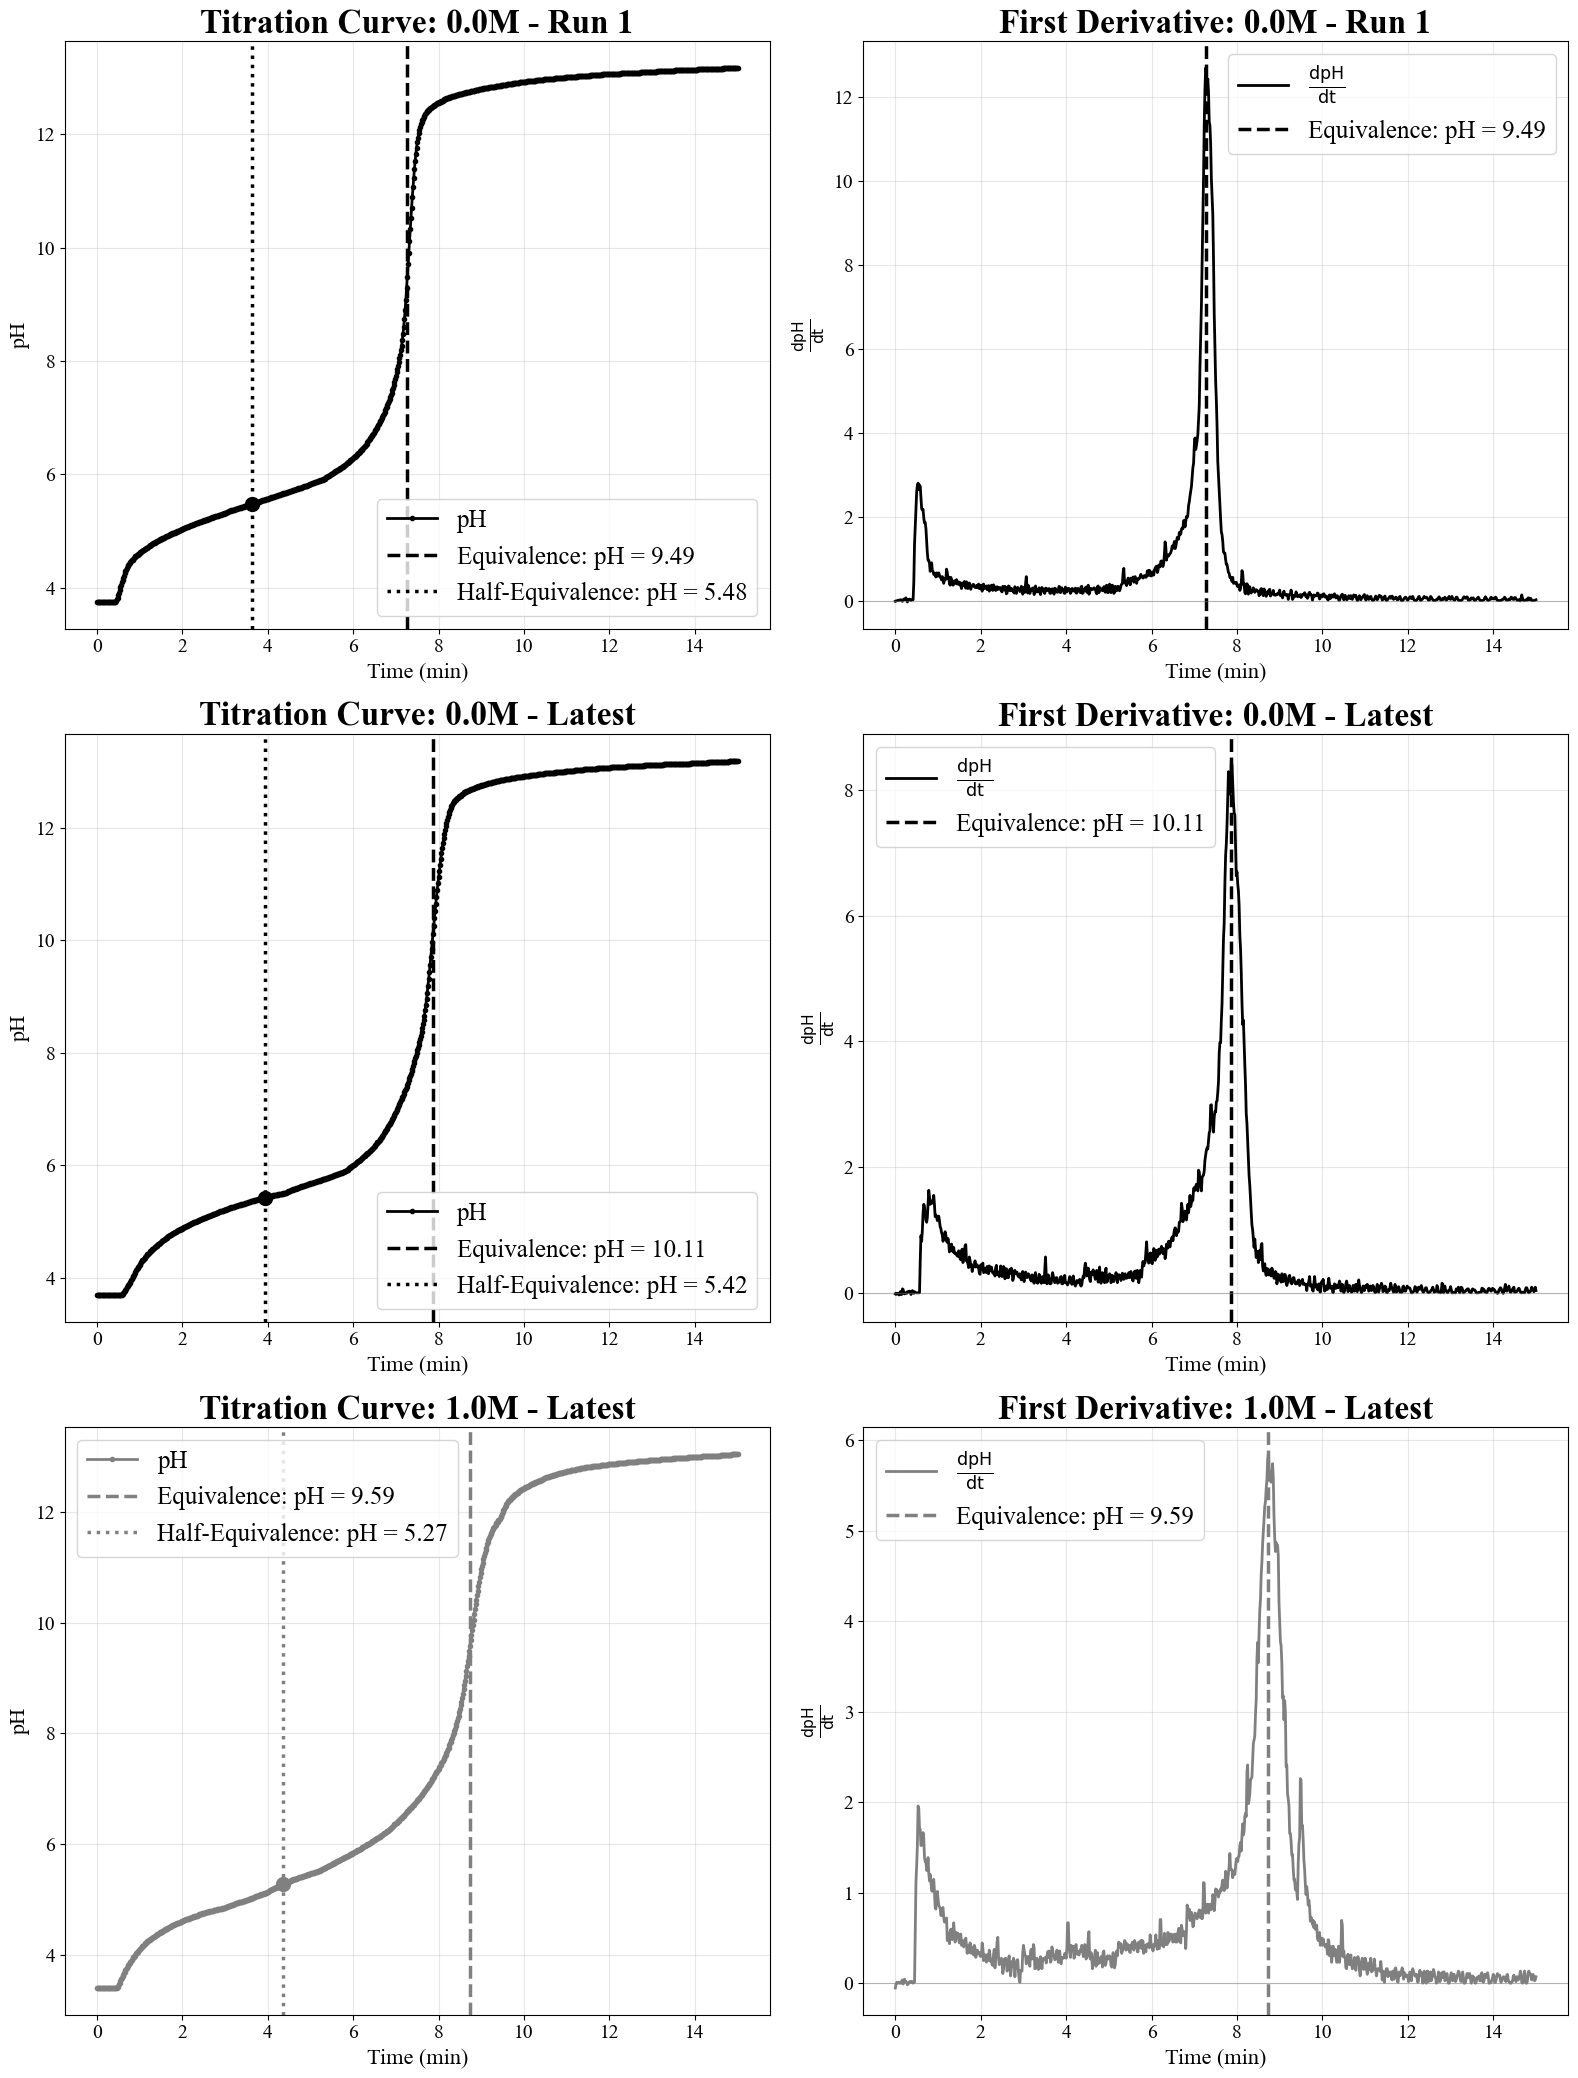

In [4]:
results_df = pd.DataFrame(
    [
        {
            "NaCl Concentration (M)": r["nacl_conc"],
            "Run": r["run_name"],
            "Equivalence Time (min)": r["eq_time"],
            "Equivalence pH": r["eq_pH"],
            "Half-Equivalence Time (min)": r["half_eq_time"],
            "Half-Equivalence pH (pKa)": r["half_eq_pH"],
        }
        for r in results
    ]
)

print(results_df)

plt.style.use("default")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14
colors = ["black", "gray"]

fig, axes = plt.subplots(len(results), 2, figsize=(16, 7 * len(results)))
if len(results) == 1:
    axes = [axes]

for i, res in enumerate(results):
    df = res["data"]
    run_name = res["run_name"]
    color = colors[int(res["nacl_conc"])]

    ax1 = axes[i][0]
    ax1.plot(
        df["Time (min)"],
        df["pH"],
        ".-",
        color=color,
        label="pH",
        linewidth=2,
        markersize=6,
    )
    ax1.axvline(
        res["eq_time"],
        color=color,
        linestyle="--",
        linewidth=2.5,
        label=f'Equivalence: pH = {res["eq_pH"]:.2f}',
    )
    ax1.axvline(
        res["half_eq_time"],
        color=color,
        linestyle=":",
        linewidth=2.5,
        label=f'Half-Equivalence: pH = {res["half_eq_pH"]:.2f}',
    )
    ax1.plot(
        res["half_eq_time"], res["half_eq_pH"], color=color, marker="o", markersize=10
    )
    ax1.set_title(f"Titration Curve: {run_name}", fontsize=24, fontweight="bold")
    ax1.set_xlabel(r"Time (min)", fontsize=16)
    ax1.set_ylabel(r"pH", fontsize=16)
    ax1.tick_params(labelsize=14)
    ax1.legend(fontsize=18)
    ax1.grid(True, alpha=0.3)

    ax2 = axes[i][1]
    ax2.plot(
        df["Time (min)"],
        df["dpH/dt"],
        "-",
        color=color,
        label=r"$\frac{dpH}{dt}$",
        linewidth=2,
    )
    ax2.axvline(
        res["eq_time"],
        color=color,
        linestyle="--",
        linewidth=2.5,
        label=f'Equivalence: pH = {res["eq_pH"]:.2f}',
    )
    ax2.axhline(0, color="gray", linestyle="-", linewidth=0.8, alpha=0.5)
    ax2.set_title(f"First Derivative: {run_name}", fontsize=24, fontweight="bold")
    ax2.set_xlabel(r"Time (min)", fontsize=16)
    ax2.set_ylabel(r"$\frac{dpH}{dt}$", fontsize=16)
    ax2.tick_params(labelsize=14)
    ax2.legend(fontsize=18)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Statistical Summary ===
 NaCl Concentration (M)  Mean pKa       SD  n      SEM  95% CI
                    0.0  5.450953 0.037561  2 0.026559 0.33747
                    1.0  5.273643      NaN  1      NaN     NaN

Individual Measurements:

0.0 M NaCl:
  0.0M - Run 1: pKa = 5.4775
  0.0M - Latest: pKa = 5.4244

1.0 M NaCl:
  1.0M - Latest: pKa = 5.2736


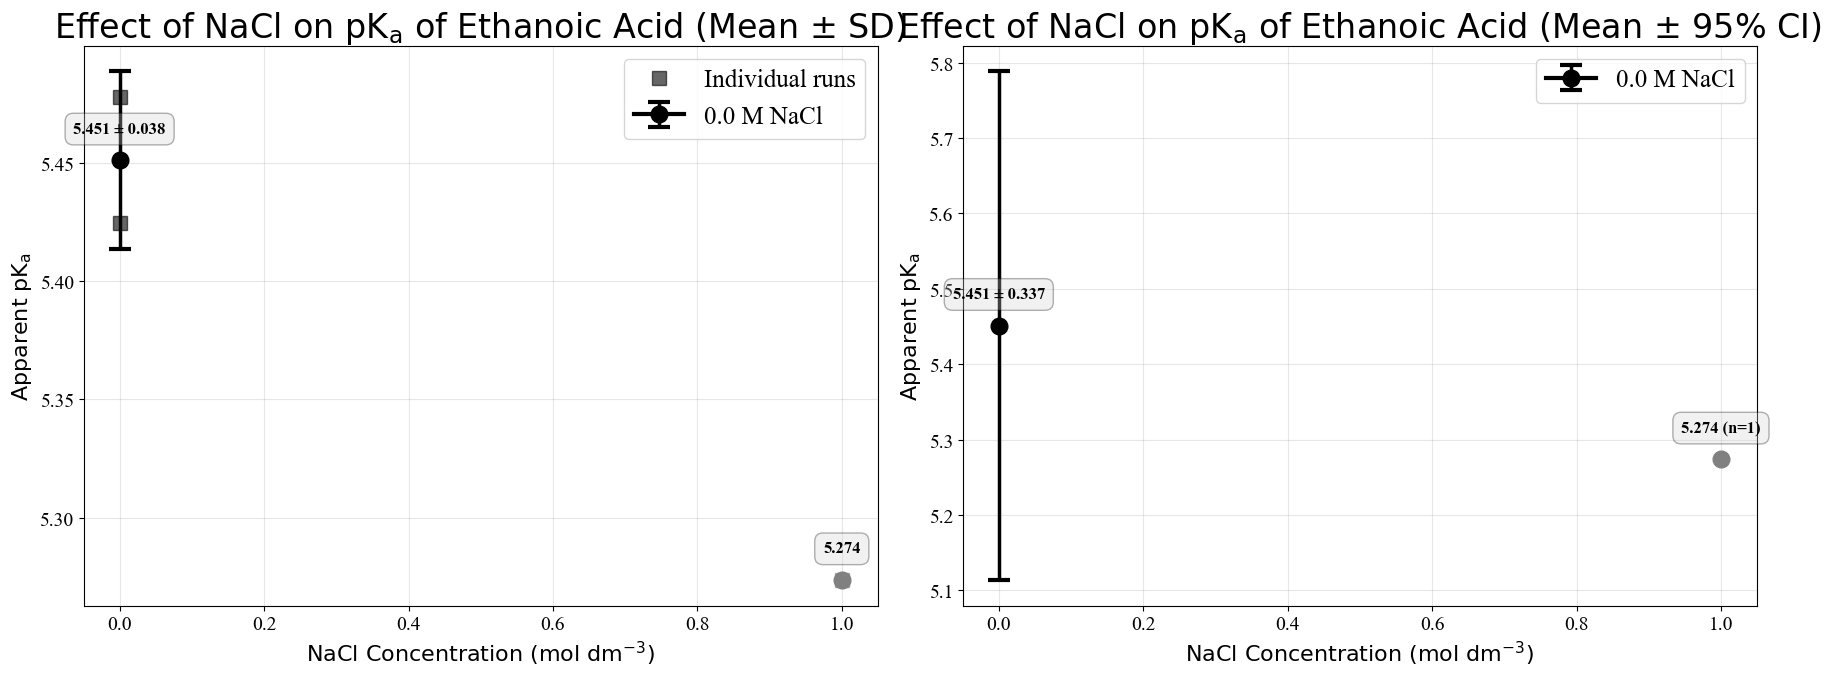

In [ ]:
stats_df = (
    results_df.groupby("NaCl Concentration (M)")["Half-Equivalence pH (pKa)"]
    .agg([("Mean pKa", "mean"), ("SD", "std"), ("n", "count")])
    .reset_index()
)

stats_df["SEM"] = stats_df["SD"] / np.sqrt(stats_df["n"])

print("\n=== Statistical Summary ===")
print(stats_df.to_string(index=False))
print("\nIndividual Measurements:")
for conc in stats_df["NaCl Concentration (M)"]:
    subset = results_df[results_df["NaCl Concentration (M)"] == conc]
    print(f"\n{conc} M NaCl:")
    for _, row in subset.iterrows():
        print(f"  {row['Run']}: pKa = {row['Half-Equivalence pH (pKa)']:.4f}")

plt.style.use("default")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14
colors = ["black", "gray"]

fig, ax1 = plt.subplots(1, 1, figsize=(9, 7))

for i, row in stats_df.iterrows():
    conc = row["NaCl Concentration (M)"]
    color = colors[i]
    ax1.errorbar(
        conc,
        row["Mean pKa"],
        yerr=row["SD"],
        fmt="o-",
        color=color,
        linewidth=3,
        markersize=12,
        capsize=8,
        capthick=3,
        label=f"{conc} M NaCl" if i == 0 else "",
        elinewidth=2.5,
    )

    subset = results_df[results_df["NaCl Concentration (M)"] == conc]
    ax1.plot(
        [conc] * len(subset),
        subset["Half-Equivalence pH (pKa)"],
        marker="s",
        color=color,
        markersize=10,
        alpha=0.6,
        linestyle="",
        label="Individual runs" if i == 0 else "",
    )

ax1.set_xlabel(r"NaCl Concentration (mol dm$^{-3}$)", fontsize=16, fontweight="bold")
ax1.set_ylabel(r"Apparent $pK_a$", fontsize=16, fontweight="bold")
ax1.set_title(
    r"Effect of NaCl on $pK_a$ of Ethanoic Acid (Mean ± SD)",
    fontsize=24,
    fontweight="bold",
)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=14)
ax1.legend(fontsize=18, loc="best")

for _, row in stats_df.iterrows():
    if pd.notna(row["SD"]):
        label = f"{row['Mean pKa']:.3f} ± {row['SD']:.3f}"
    else:
        label = f"{row['Mean pKa']:.3f}"
    ax1.annotate(
        label,
        (row["NaCl Concentration (M)"], row["Mean pKa"]),
        textcoords="offset points",
        xytext=(0, 20),
        ha="center",
        fontsize=12,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.3),
    )

plt.tight_layout()
plt.show()